### Fitting Matrix entries
In this Notebook the matrix entries for both quarter-wave plates were fitted using least squares fits from scipy. In this version only some entries are non-zero like in the matrix below. Additionally they are bounded between -1 and 1. The matrix used for the fits looks like $$\begin{bmatrix}
 a_{11} & 0 & 0 & 0\\
0 & a_{22} & 0 & 0\\
 0 & 0 & a_{33}& a_{34} \\
  0 & 0 & a_{43} & a_{44}
\end{bmatrix}$$ and a $\in$ [-1,1]

The matrix for an ideal retarder with arbitrary retardance and $\alpha$=0 looks like
$$\begin{bmatrix}
 1 & 0 & 0 & 0\\
0 & D^2 + G^2 & 0 & 0\\
 0 & 0 & -D^2 + G^2 & 2DG \\
  0 & 0 & -2DG & 2 G^2 -1
\end{bmatrix}$$

In [21]:
import numpy as np
import matplotlib.pyplot as plt

from sympy import Symbol, cos, sin, pi, sqrt, symbols, acos, asin
from sympy.matrices import *
from sympy.utilities.lambdify import lambdify
from sympy.interactive.printing import init_printing
from sympy.interactive import printing
printing.init_printing(use_latex=True)

from scipy.optimize import curve_fit, minimize

import os
from os.path import join, getsize

def multiple_formatter(denominator=2, number=np.pi, latex='\pi'):
    def gcd(a, b):
        while b:
            a, b = b, a%b
        return a
    def _multiple_formatter(x, pos):
        den = denominator
        num = np.int(np.rint(den*x/number))
        com = gcd(num,den)
        (num,den) = (int(num/com),int(den/com))
        if den==1:
            if num==0:
                return r'$0$'
            if num==1:
                return r'$%s$'%latex
            elif num==-1:
                return r'$-%s$'%latex
            else:
                return r'$%s%s$'%(num,latex)
        else:
            if num==1:
                return r'$\frac{%s}{%s}$'%(latex,den)
            elif num==-1:
                return r'$\frac{-%s}{%s}$'%(latex,den)
            else:
                return r'$\frac{%s%s}{%s}$'%(num,latex,den)
    return _multiple_formatter

class Multiple:
    def __init__(self, denominator=2, number=np.pi, latex='\pi'):
        self.denominator = denominator
        self.number = number
        self.latex = latex

    def locator(self):
        return plt.MultipleLocator(self.number / self.denominator)

    def formatter(self):
        return plt.FuncFormatter(multiple_formatter(self.denominator, self.number, self.latex))


# define symbols
theta = Symbol('theta') # angle for rotation matrix
theta_0 = Symbol('theta_0')
a11 = Symbol('a_11')
a12 = Symbol('a_12')
a13 = Symbol('a_13')
a14 = Symbol('a_14')
a21 = Symbol('a_21')
a22 = Symbol('a_22')
a23 = Symbol('a_23')
a24 = Symbol('a_24')
a31 = Symbol('a_31')
a32 = Symbol('a_32')
a33 = Symbol('a_33')
a34 = Symbol('a_34')
a41 = Symbol('a_41')
a42 = Symbol('a_42')
a43 = Symbol('a_43')
a44 = Symbol('a_44')

Define rotation and Müller matrices. Replace some entries of the general Müller matrix with values from the theoretical prediction for a better fit. In the rotation matrix an additional parameter $\Theta_{0}$ was introduced to account for the unknown main axis of the wave-plate.

In [22]:
# matrix for a rotation
R = Matrix([
    [1.0, 0.0, 0.0, 0.0],
    [0.0, cos(2*(theta+theta_0)), sin(2*(theta+theta_0)), 0.0],
    [0.0, -sin(2*(theta+theta_0)), cos(2*(theta+theta_0)), 0.0],
    [0.0, 0.0, 0.0, 1.0]
])

# random mueller matrix
M = Matrix([
    [a11, a12, a13, a14],
    [a21, a22, a23, a24],
    [a31, a32, a33, a34],
    [a41, a42, a43, a44]
])
#M = M.subs({a21: a12, a31: a13, a32: a23, a41: a14, a42: a24, a43: a34})
# Had to put very small values in instead of zeros, otherwise error in lambdify function, which says:
# error: setting an array element with a sequence. Not clear what that means
M = M.subs({a12:0, a21:0, a32:0,
            a23:0, a41:0, a14:0, a24:0, a31:0, a13:0.00000000001,a42:0})

### Read in data for all wave-plates and do the fit
Data for 4 different wave-plates is read in, but we regard only the quarter-wave plates


In [23]:
# rotate the mueller matrix
M = R.T*M*R

directories=[]
# Read-in day 1
for root, dirs, files in os.walk('20190418/'):
    if files != []:
        a=str(root)+str('/')+str(files[0])
        directories.append(a)
# First four directories in 20190418 are the measurements for the waveplates, with following names
names=['1/2 600-2700', '14_600-2700','QWP01', '1/2 # 40']
# Select only half-wave plates
directories=directories[0:4]



matrices=[]

for i in np.arange(len(directories)):
    # load data of experiment
    data = np.loadtxt(directories[i])
    
    # convert angles into radian
    data[:,1] = data[:,1] / 180. * np.pi
    
    #get absolute stokes vectors
    data[:,2] *= data[:,6]
    data[:,3] *= data[:,6]
    data[:,4] *= data[:,6]
    
    # initial stokes vector (withot the optical component) for every read-in measurement
    names=['1/2 600-2700', '1/4 600-2700','QWP01', '1/2 # 40']
    S_i = [ 0.0000191866874*Matrix([
        np.sqrt(0.489**2.+0.637**2.+0.594**2.), 
        -0.489, 0.637, 0.594]),
                    0.00001380384264*Matrix([
        np.sqrt(0.534**2.+0.616**2.+0.577**2.), 
        -0.534, 0.616, 0.577]),
                    0.0000193642196*Matrix([
        np.sqrt(0.481**2.+0.718**2.+0.502**2.), 
        0.481, 0.718, 0.502]),
                    0.0000198152702*Matrix([
        np.sqrt(0.447**2.+0.734**2.+0.510**2.), 
        0.447, 0.734, -0.510])  ]
    # Same stokes vector, but normalized
    S_i_normalized= [Matrix([
        np.sqrt(0.489**2.+0.637**2.+0.594**2.), 
        -0.489, 0.637, 0.594]),
                    Matrix([
        np.sqrt(0.534**2.+0.616**2.+0.577**2.), 
        -0.534, 0.616, 0.577]),
                    Matrix([
        np.sqrt(0.481**2.+0.718**2.+0.502**2.), 
        0.481, 0.718, 0.502]),
                    Matrix([
        np.sqrt(0.447**2.+0.734**2.+0.510**2.), 
        0.447, 0.734, -0.510])]
    S_i_normalized_DOP= [ Matrix([
        np.sqrt(0.489**2.+0.637**2.+0.594**2.), 
        -0.489*99.3/100, 0.637*99.3/100, 0.594*99.3/100]),
                          Matrix([
        np.sqrt(0.534**2.+0.616**2.+0.577**2.), 
        -0.534*99.2/100, 0.616*99.2/100, 0.577*99.2/100]),
                          Matrix([
        np.sqrt(0.481**2.+0.718**2.+0.502**2.), 
        0.481*100.15/100, 0.718*100.15/100, 0.502*100.15/100]),
                          Matrix([
        np.sqrt(0.447**2.+0.734**2.+0.510**2.), 
        0.447*100.3/100, 0.734*100.3/100, -0.510*100.3/100])  ]
    # simulate and fit experiment
    
    # take incoming stokes vector
    # multiply incoming stokes vector by matrix M
    S_f = M*S_i_normalized_DOP[i]
    
    # back function to later rotate the matrix back in case it is rotated by 45 degrees, a bit redundant 
    # but ok for now
    
    back= R.T*M*R
    # Define function, which takes incoming beam and matrix parameters
    # and returns the matrix multiplied by stokes vector
    S_f_function = lambdify([
        theta,theta_0,
        a11, a22, a33, a34,a43, a44],
        S_f, 'numpy')
    
    back_rotation = lambdify([
        theta,theta_0,
        a11, a22, a33, a34,
        a43, a44],
        back, 'numpy')
    
    def back_function(theta,theta_0,
                       a11, a22,
                     a33, a34,
                        a43, a44):
        # Give incoming matrix parameters and it returns outgoing stokes vector
        S = back_rotation(theta, theta_0, 
                         a11, a22, a33, a34, a43, a44)
        return S
    
    def fit_function_S(theta,theta_0,
                       a11, a22, a33, a34, a43, a44):
        # Give incoming matrix parameters and it returns outgoing stokes vector
        S = S_f_function(theta, theta_0, 
                         a11, a22, a33, a34, a43, a44)
        #return S[1][0]
        #return np.concatenate((len(theta)*[S[0][0]], S[1][0], S[2][0], S[3][0]))
        return np.concatenate((S[0][0], S[1][0], S[2][0], S[3][0]))
    
    #print('fit function',fit_function_S(0,1, 1, 1, 0, 1, -1, 0))
    # Four entries in array
    
    S_conc = np.concatenate((data[:,6]/data[:,6], (data[:,2]*data[:,5]/100)/data[:,6],
                             (data[:,3]*data[:,5]/100)/data[:,6], (data[:,4]*data[:,5]/100)/data[:,6]) )
    #print(data[:,6]/np.sqrt(data[:,2]**2 + data[:,3]**2 +data[:,4]**2 ))
    S_conc_err=np.concatenate( (data[:,6]/10, data[:,2]/10, data[:,3]/10, data[:,4]/10) )
    # We feed fit function with angles and recorded data. It returns entries of
    # matrix
    

    # Define bounds for the non-zero parameters
    popt_S, pcov_S = curve_fit(fit_function_S, data[:,1], S_conc, bounds=(([-7,-1,-1,-1,-1, -1, -1],
                                                                           [7,1,1,1,1,1,1])))
    perr_S = np.sqrt(np.absolute(np.diag(pcov_S)))
    
    M_fit = Matrix([
        [popt_S[1], 0,0,0 ],
        [0, popt_S[2],0,0 ],
        [0,0, popt_S[3], popt_S[4]],
        [0,0, popt_S[5], popt_S[6]]
    ])
    
    matrices.append(M_fit)
    
    # Some errors are also calculated put not put in use yet
    
    S0_fit = fit_function_S(data[:,1], *popt_S)[:data.shape[0]]
    S0_fit_err = fit_function_S(data[:,1], *perr_S)[:data.shape[0]]
    S1_fit = fit_function_S(data[:,1], *popt_S)[data.shape[0]:2*data.shape[0]]
    S1_fit_err = fit_function_S(data[:,1], *perr_S)[data.shape[0]:2*data.shape[0]]
    S2_fit = fit_function_S(data[:,1], *popt_S)[2*data.shape[0]:3*data.shape[0]]
    S2_fit_err = fit_function_S(data[:,1], *perr_S)[2*data.shape[0]:3*data.shape[0]]
    S3_fit = fit_function_S(data[:,1], *popt_S)[3*data.shape[0]:4*data.shape[0]]
    S3_fit_err = fit_function_S(data[:,1], *perr_S)[3*data.shape[0]:4*data.shape[0]]
    DOP_fit = np.sqrt(S1_fit**2.+S2_fit**2.+S3_fit**2.)/S0_fit
    #print(S0_fit)
    # From Gaussian error propagation
    DOP_fit_err = np.sqrt( (S1_fit*S1_fit_err/(np.sqrt(S1_fit**2.+S2_fit**2.+S3_fit**2.)*S0_fit))**2 
    + (S2_fit*S2_fit_err/(np.sqrt(S1_fit**2.+S2_fit**2.+S3_fit**2.)*S0_fit))**2 
    + (S3_fit*S3_fit_err/(np.sqrt(S1_fit**2.+S2_fit**2.+S3_fit**2.)*S0_fit))**2 
    + (S0_fit_err*np.sqrt(S1_fit**2.+S2_fit**2.+S3_fit**2.)/S0_fit**2)**2 )
    
    import matplotlib as mpl
    mpl.use('pdf')

    #Direct input 
    plt.rcParams['text.latex.preamble']=[r"\usepackage{lmodern}"]
    #Option

    plt.rc('text', usetex=True)
    plt.rc('xtick', labelsize=5.2)
    plt.rc('ytick', labelsize=5.2)
    plt.rc('axes', labelsize=5.2)

    # width as measured in inkscape
    width = 3.487
    height = width / 1.618


    # Select only quarter-wave plates
    if i==1 or i==2:
        fig, ax = plt.subplots(1, 1, sharex=True, figsize=(9.5,3.5))
        fig.subplots_adjust(left=.19, bottom=.22, right=.99, top=.97)
        fig.set_size_inches(width, height)
        fig1, ax1 = plt.subplots(1, 1, sharex=True, figsize=(9.5,3.5))
        fig2, ax2 = plt.subplots(1, 1, sharex=True, figsize=(9.5,3.5))
        fig3, ax3 = plt.subplots(1, 1, sharex=True, figsize=(9.5,3.5))
        
        ax.xaxis.set_major_locator(plt.MultipleLocator(np.pi/2))
        ax.xaxis.set_minor_locator(plt.MultipleLocator(np.pi/8))
        ax.xaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))
        
        ax.set_title(str(names[i])+ ' in W')
        ax.plot(data[:,1], data[:,6], label='S0')
        ax.plot(data[:,1], S0_fit*data[:,6], c='C0', linestyle='--')
        #ax.errorbar(data[:,1], ((data[:,2]*data[:,5]/100)/data[:,6]-S1_fit), c='C0')
        ax.plot(data[:,1], data[:,2], label='S1')
        ax.plot(data[:,1], S1_fit*data[:,6], c='C1', linestyle='--')
        ax1.set_title('Residuals with errorbars for S1')
        ax1.set_xlabel('angle')
        ax1.set_ylabel('Res S1')
        ax1.errorbar(data[:,1], ((data[:,2]*data[:,5]/100)/data[:,6]-S1_fit),
                     yerr=(((data[:,2]*data[:,5]/100)/data[:,6])*0.0206574007757285 +0.005) ,c='C1')
        ax.plot(data[:,1], data[:,3], label='S2')
        ax.plot(data[:,1], S2_fit*data[:,6], c='C2', linestyle='--')
        ax2.set_title('Residuals with errorbars for S2')
        ax2.set_xlabel('angle')
        ax2.set_ylabel('Res S2')
        ax2.errorbar(data[:,1], ((data[:,3]*data[:,5]/100)/data[:,6]-S2_fit),
                     yerr=(((data[:,3]*data[:,5]/100)/data[:,6])*0.007608529727302959 +0.005) ,c='C2')
        #ax.errorbar(data[:,1], ((data[:,3]*data[:,5]/100)/data[:,6]-S2_fit), c='C2')
        ax.plot(data[:,1], data[:,4], label='S3')
        ax.plot(data[:,1], S3_fit*data[:,6], c='C3', linestyle='--')
        ax3.set_title('Residuals with errorbars for S3')
        ax3.set_xlabel('angle')
        ax3.set_ylabel('Res S3')
        ax3.errorbar(data[:,1], ((data[:,4]*data[:,5]/100)/data[:,6]-S3_fit),
                     yerr=(((data[:,4]*data[:,5]/100)/data[:,6])*0.0004296509074752014 +0.005) ,c='C3')
        #ax.errorbar(data[:,1], ((data[:,4]*data[:,5]/100)/data[:,6]-S3_fit), c='C3')
        ax.set_xlabel('angle')
        ax.set_ylabel('stokes parameter [W]')
        ax.legend();

        fig, ax = plt.subplots(1, 1, sharex=True, figsize=(9.5,3.5))
        
        fig.subplots_adjust(left=.15, bottom=.16, right=.99, top=.97)
        fig.set_size_inches(width, height)
        
        #ax.set_title(str(names[i])+ ' DOP')
        ax.plot(data[:,1], 1e-2*data[:,5], label='DOP', linewidth=0.6)
        ax.plot(data[:,1], DOP_fit, c='C0', linestyle='--', linewidth=0.6)
        ax.plot(data[:,1], data[:,2]/data[:,6], label='M', linewidth=0.6)
        ax.plot(data[:,1], S1_fit/S0_fit, c='C1', linestyle='--', linewidth=0.6)
        ax.plot(data[:,1], data[:,3]/data[:,6], label='C', linewidth=0.6)
        ax.plot(data[:,1], S2_fit/S0_fit, c='C2', linestyle='--', linewidth=0.6)
        ax.plot(data[:,1], data[:,4]/data[:,6], label='S', linewidth=0.6)
        ax.plot(data[:,1], S3_fit/S0_fit, c='C3', linestyle='--', linewidth=0.6)
        ax.set_xlabel('$\Theta\ (deg)$')
        ax.set_ylabel('Normalized Stokes parameter / DOP')
        ax.legend();
        ax.xaxis.set_major_locator(plt.MultipleLocator(np.pi/2))
        ax.xaxis.set_minor_locator(plt.MultipleLocator(np.pi/8))
        ax.xaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))
        fig.savefig(str(i)+'_fit.pdf',fmt='pdf')
        plt.show()
        # Added 0.005 error from polarimeter manual
        res_S0=np.sum( (data[:,6]/data[:,6]-S0_fit)**2 )
        res_S1=np.sum( ( ((data[:,2]*data[:,5]/100)/data[:,6]-S1_fit) /
                        (((data[:,2]*data[:,5]/100)/data[:,6])*0.0206574007757285 +0.005))**2 ) 
        res_S2=np.sum( ( ((data[:,3]*data[:,5]/100)/data[:,6]-S2_fit) /
                        (((data[:,3]*data[:,5]/100)/data[:,6])*0.007608529727302959 +0.005))**2 )
        res_S3=np.sum( ( ((data[:,4]*data[:,5]/100)/data[:,6]-S3_fit) /
                        (((data[:,4]*data[:,5]/100)/data[:,6])*0.0004296509074752014 +0.005))**2 ) 
        res_DOP=np.sum( (1e-2*data[:,5]-DOP_fit)**2 )
    
        chi_2_S1= res_S1/360
        chi_2_S2= res_S2/360
        chi_2_S3= res_S3/360
        
        print('res_S0', res_S0)
        print('res_S1', res_S1)
        print('res_S2', res_S2)
        print('res_S3', res_S3)
        print('res_DOP', res_DOP)
        
        print('chi_2_S1_DOF', chi_2_S1)
        print('chi_2_S2_DOF', chi_2_S2)
        print('chi_2_S3_DOF', chi_2_S3)
    
R_90 = Matrix([
    [1.0, 0.0, 0.0, 0.0],
    [0.0, cos(2*(np.pi/2)), sin(2*(np.pi/2)), 0.0],
    [0.0, -sin(2*(np.pi/2)), cos(2*(np.pi/2)), 0.0],
    [0.0, 0.0, 0.0, 1.0]
])

#matrices=[matrices[i]/matrices[i][0][0] for i in np.arange(len(matrices))]

# Rotate the matrices by 90 degrees to get the signs right.

matrices[1]=R_90.T*matrices[1]*R_90

matrices[2]=R_90.T*matrices[2]*R_90

C:\Users\P\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


res_S0 0.0005463849472737506
res_S1 697665.0511271228
res_S2 31177096.734750226
res_S3 28673.102696544876
res_DOP 0.13116007669282279
chi_2_S1_DOF 1937.958475353119
chi_2_S2_DOF 86603.04648541729
chi_2_S3_DOF 79.64750749040243
res_S0 0.0001114593945418688
res_S1 237908.96280542304
res_S2 11222.770557945356
res_S3 6345.287599287723
res_DOP 0.08294455978962378
chi_2_S1_DOF 660.858230015064
chi_2_S2_DOF 31.17436266095932
chi_2_S3_DOF 17.625798886910342


### Test Matrices on theoretical polarizations

'1/4 600-2700'

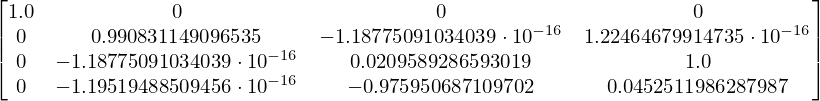

'QWP01'

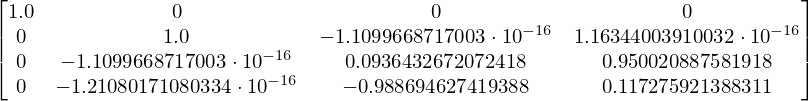

In [24]:
# Check retardance
display(str(names[1]),matrices[1])
display(str(names[2]),matrices[2])

We see that these matrices come close to the desired Müller matrices for a quarter-wave plate, which looks like

$$\begin{bmatrix}
 1 & 0 & 0 & 0\\
0 & 1 & 0 & 0\\
 0 & 0 & 0& 1 \\
  0 & 0 & -1 & 0
\end{bmatrix}$$ 
There is some intensity absorption, which is about 10 % for the first plate and about 30 % percent for the second one. This is a bit high for the second plate, but still reasonable. 
There are non-zero entries for the lower part of the diagonal, which are not expected, but still in the tolerable range. 
A problem is that for both matrices there are entries, which are higher than $a_{11}$, which leads to outgoing Stokes vectors with values higher than 1. The reason for that is yet unknown, probably because of the oscillating DOP or inappropriate fit routine

### Compare with theoretical expectations

We compute the effects of ideal quarter-wave plates on Stokes vectors for different polarizations to compare with our results from the fits.

In [25]:
S_H=Matrix([1,1,0,0])
S_D=Matrix([1,0,1,0])
S_R=Matrix([1,0,0,1])
matrix_ideal=Matrix([[1,0,0,0],[0,1,0,0],[0,0,0,1],[0,0,-1,0]])
S_H_prime_0=matrices[1] *S_H
S_H_prime_1=matrices[2]*S_H

S_D_prime_0=matrices[1]*S_D
S_D_prime_1=matrices[2]*S_D

S_R_prime_0=matrices[1]*S_R
S_R_prime_1=matrices[2]*S_R

S_H_ideal=matrix_ideal*S_H
S_D_ideal=matrix_ideal*S_D
S_R_ideal=matrix_ideal*S_R

delta_H_0 = (S_H[1]-S_H_prime_0[1])
delta_H_1 = (S_H[1]-S_H_prime_1[1])

delta_D_0 = (S_D[2]-S_D_prime_0[2])
delta_D_1 = (S_D[2]-S_D_prime_0[2])

retardance_0= (delta_D_0-delta_H_0)*180/2
retardance_1= (delta_D_1-delta_H_1)*180/2

print(retardance_0)
print(retardance_1)

87.2884998393510
88.1136964206628


If the quarter-wave plate acts upon horizontal polarization under the angle $\alpha$=0 there is only intensity absorption, as expected.

'Horizontal polarization on 1/4 600-2700'

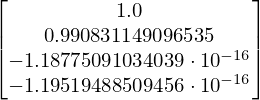

'Horizontal polarization on QWP01'

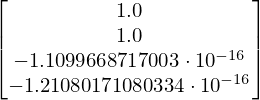

In [26]:
display('Horizontal polarization on '+str(names[1]), S_H_prime_0)   
display('Horizontal polarization on '+str(names[2]), S_H_prime_1)  

If the quarter-wave plate acts upon diagonal polarization under the angle $\alpha$=0, we get left-handed polarization, as expected.

'Diagonal polarization on 1/4 600-2700'

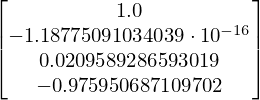

'Diagonal polarization on QWP01'

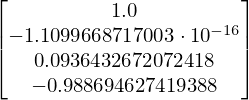

In [27]:
display('Diagonal polarization on '+str(names[1]), S_D_prime_0)   
display('Diagonal polarization on '+str(names[2]), S_D_prime_1)

If the quarter-wave plate acts upon right-handed polarization under the angle $\alpha$=0, we get diagonal polarization, as expected.

'Right-handed polarization on 1/4 600-2700'

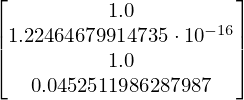

'Right-handed polarization on QWP01'

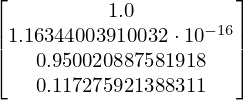

S_H ideal Matrix([[1], [1], [0], [0]])
S_D ideal Matrix([[1], [0], [0], [-1]])
S_R ideal Matrix([[1], [0], [1], [0]])


In [28]:
display('Right-handed polarization on '+str(names[1]), S_R_prime_0)   
display('Right-handed polarization on '+str(names[2]), S_R_prime_1)


print('S_H ideal', S_H_ideal)
print('S_D ideal', S_D_ideal)
print('S_R ideal', S_R_ideal)

The results are acceptable, except that some entries are higher than the intensity

### Calculating retardance from matrix entries

This section is just for testing purposes and not relevant for the determination of the retardance

The Müller matrix for any retardance $\delta$ and $\alpha$=0 is
$$\begin{bmatrix}
 1 & 0 & 0 & 0\\
0 & D^2 + G^2 & 0 & 0\\
 0 & 0 & -D^2 + G^2 & 2DG \\
  0 & 0 & -2DG & 2 G^2 -1
\end{bmatrix}$$ with D=$M sin(\frac{1}{2} \delta)$ and G=$cos \frac{1}{2} \delta$

We normalize the intensity to 1 for the computed matrices. To compute the retardance we use some of the entries.
For the quarter-wave plate 600-2700 nm we get

'1/4 600-2700'

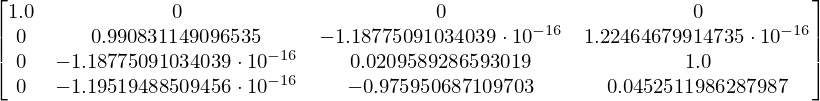

'QWP01'

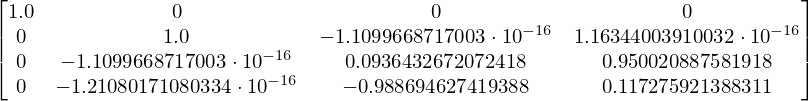

delta from a_44= 1.52552967065749
delta from a_44 in degree= 87.4064116506564
delta from a_43  -1.5707963267949 + 1.21116571856647*I
delta from a_34  1.5707963267949 - 1.2401012719321*I


In [29]:
display(str(names[1]),matrices[1]/matrices[1][0])
display(str(names[2]),matrices[2]/matrices[2][0])

M0=S_i_normalized[1]
#print(-matrices[1][11]/matrices[1][0])

# Compute the retardance from the entries
a=acos(sqrt(((matrices[1][15]/matrices[1][0] +1)/2)))*2
b1=asin((-matrices[1][14]/matrices[1][0])/M0[1])
b2=asin((-matrices[1][11]/matrices[1][0])/M0[1])
print('delta from a_44=',a)
print('delta from a_44 in degree=',a/np.pi *180)
print('delta from a_43 ', b1)
print('delta from a_34 ', b2)

We see that the values from the side entries are not really usable, but for the result from $a_{44}$ we get an accurate description of the retardance. 
For the other quarter-wave plate we get

In [30]:
M0=S_i_normalized[2]
print(-matrices[2][11]/matrices[2][0])
a=acos(sqrt(((matrices[2][15]/matrices[2][0] +1)/2)))*2
b1=asin((-matrices[2][14]/matrices[2][0])/M0[1])
b2=asin((-matrices[2][11]/matrices[2][0])/M0[1])
print('delta from a_44=',a)
print('delta from a_44 in degree=',a/np.pi *180)
print('delta from a_43 ', b1)
print('delta from a_34 ', b2)

-0.950020887581918
delta from a_44= 1.45324989933852
delta from a_44 in degree= 83.2650858099092
delta from a_43  1.5707963267949 - 1.34842294488882*I
delta from a_34  -1.5707963267949 + 1.30245834517586*I
